# Predicting Overall Survival on TCGA Datasets Through Supervised Machine Learning Models
### Shaita Picard
### May 2, 2018

In [258]:
# import required modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from lifelines.estimation import KaplanMeierFitter

The data used in this project was exported directly from the GDC Portal of The National Cancer Institute (NCI) (https://portal.gdc.cancer.gov/repository). This portal provides a repository of over 50 different primary cancer types and publicly available data for individuals affected by these cancers. For this particular project, I have selected just 3 different cancer types from the TCGA project on which to explore supervised machine learning techniques to predict survival based solely on clinical characteristics: Lung, Kidney, and Colorectal. The GDC export packages the selected cancer types into one folder. 

In [259]:
# read in the required datasets
clinical = pd.read_csv("./clinical.cart.2018-04-30/clinical.tsv",sep="\t")

It's always good practice to start by looking at your data and getting a sense of what's in there.

In [260]:
clinical.head()

,case_id,submitter_id,project_id,gender,year_of_birth,race,ethnicity,year_of_death,classification_of_tumor,last_known_disease_status,...,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy
0,d9121e5a-88f2-47a6-a0b1-25735c209e54,TCGA-AH-6644,TCGA-READ,male,1937,white,not reported,--,not reported,not reported,...,not reported,C19.9,-26892.0,not reported,not reported,C19.9,838.0,--,--,--
1,c69dec57-7a84-481b-bcfe-61a771d0a9d1,TCGA-AG-3602,TCGA-READ,female,1941,not reported,not reported,--,not reported,not reported,...,not reported,C19.9,-24350.0,not reported,not reported,C19.9,0.0,--,--,--
2,3f10de1e-c8ce-415e-b4e1-e50901686a2f,TCGA-DT-5265,TCGA-READ,male,1959,asian,not hispanic or latino,--,not reported,not reported,...,not reported,C20.9,-18669.0,not reported,not reported,C20.9,384.0,--,--,--
3,0b6b1937-4024-4f2c-aeca-46387277755f,TCGA-EF-5830,TCGA-READ,male,1956,white,not hispanic or latino,--,not reported,not reported,...,not reported,C20.9,-19802.0,not reported,not reported,C20.9,106.0,--,--,--
4,85947797-54b8-44fb-910b-5cd689542994,TCGA-F5-6571,TCGA-READ,female,1949,white,not hispanic or latino,--,not reported,not reported,...,not reported,C20.9,-22666.0,not reported,not reported,C20.9,1288.0,--,--,--


More data exploration.

In [261]:
# Check for nulls in the dataset
clinical.isnull().any()

case_id                              False
submitter_id                         False
project_id                           False
gender                               False
year_of_birth                        False
race                                 False
ethnicity                            False
year_of_death                        False
classification_of_tumor              False
last_known_disease_status            False
primary_diagnosis                    False
tumor_stage                          False
age_at_diagnosis                     False
vital_status                         False
morphology                           False
days_to_death                        False
days_to_last_known_disease_status    False
days_to_recurrence                   False
tumor_grade                          False
tissue_or_organ_of_origin            False
days_to_birth                        False
progression_or_recurrence            False
prior_malignancy                     False
site_of_res

In [262]:
print(clinical.columns.tolist())

['case_id', 'submitter_id', 'project_id', 'gender', 'year_of_birth', 'race', 'ethnicity', 'year_of_death', 'classification_of_tumor', 'last_known_disease_status', 'primary_diagnosis', 'tumor_stage', 'age_at_diagnosis', 'vital_status', 'morphology', 'days_to_death', 'days_to_last_known_disease_status', 'days_to_recurrence', 'tumor_grade', 'tissue_or_organ_of_origin', 'days_to_birth', 'progression_or_recurrence', 'prior_malignancy', 'site_of_resection_or_biopsy', 'days_to_last_follow_up', 'therapeutic_agents', 'treatment_intent_type', 'treatment_or_therapy']


There are lots of columns included that may not be necessary (or useful) in predicting survival. For example, there are several id columns that are not useful for predicting survival. We'll drop case_id and submitter_id to narrow our focus. Year of Birth and Year of Death don't really matter here either. We could potentially factor age into our death analysis, but we're more interested in if we can predict death based on clinical characteristics, not age.

In [263]:
clinical.drop(columns=["case_id","submitter_id","year_of_birth","year_of_death","days_to_birth"],inplace=True)

We'll keep project_id for further exploration later on if the disease type has an effect on survival. Are there other columns we should drop?

In [264]:
clinical.describe()

,project_id,gender,race,ethnicity,classification_of_tumor,last_known_disease_status,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status,...,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy
count,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596,...,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596
unique,7,2,5,3,1,1,22,15,2279,2,...,1,1,19,1,1,19,1290,1,1,1
top,TCGA-KIRC,male,white,not hispanic or latino,not reported,not reported,C64.9,stage i,--,alive,...,--,not reported,C64.9,not reported,not reported,C64.9,--,--,--,--
freq,537,1572,1808,1731,2596,2596,650,612,49,1825,...,2596,2596,941,2596,2596,941,490,2596,2596,2596


Several columns are mostly or all values of "not reported". This is also not helpful for our analysis. Let's drop these columns too.

In [265]:
clinical["classification_of_tumor"].value_counts(dropna=False)

not reported    2596
Name: classification_of_tumor, dtype: int64

In [266]:
clinical["last_known_disease_status"].value_counts(dropna=False)

not reported    2596
Name: last_known_disease_status, dtype: int64

In [267]:
clinical["days_to_last_known_disease_status"].value_counts(dropna=False)

--    2596
Name: days_to_last_known_disease_status, dtype: int64

In [268]:
clinical["days_to_recurrence"].value_counts(dropna=False)

--    2596
Name: days_to_recurrence, dtype: int64

In [269]:
clinical["tumor_grade"].value_counts(dropna=False)

not reported    2596
Name: tumor_grade, dtype: int64

In [270]:
clinical["prior_malignancy"].value_counts(dropna=False)

not reported    2596
Name: prior_malignancy, dtype: int64

In [271]:
clinical["therapeutic_agents"].value_counts(dropna=False)

--    2596
Name: therapeutic_agents, dtype: int64

In [272]:
clinical["treatment_intent_type"].value_counts(dropna=False)

--    2596
Name: treatment_intent_type, dtype: int64

In [273]:
clinical["treatment_or_therapy"].value_counts(dropna=False)

--    2596
Name: treatment_or_therapy, dtype: int64

In [274]:
clinical.drop(columns=["classification_of_tumor","last_known_disease_status","days_to_last_known_disease_status","days_to_recurrence","tumor_grade","progression_or_recurrence","prior_malignancy","therapeutic_agents","treatment_intent_type","treatment_or_therapy"],inplace=True)

One last look to see if we're ready to start investigating the data.

In [275]:
clinical.describe()

,project_id,gender,race,ethnicity,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status,morphology,days_to_death,tissue_or_organ_of_origin,site_of_resection_or_biopsy,days_to_last_follow_up
count,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596
unique,7,2,5,3,22,15,2279,2,25,617,19,19,1290
top,TCGA-KIRC,male,white,not hispanic or latino,C64.9,stage i,--,alive,8140/3,--,C64.9,C64.9,--
freq,537,1572,1808,1731,650,612,49,1825,848,1835,941,941,490


In [276]:
# Vital Status will be the label for this data set. Make sure there are no nulls.
clinical.vital_status.value_counts(dropna=False)

alive    1825
dead      771
Name: vital_status, dtype: int64

Now the fun begins. Before we dive into our machine learning models, let's explore the data a bit further.

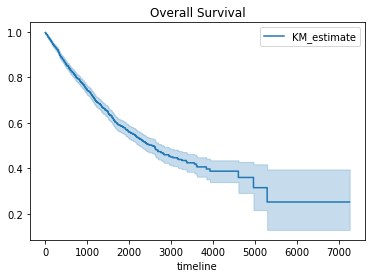

In [277]:
# Plot Survival Curve
kmf = KaplanMeierFitter()

# Let's work with a copy of our cleaned dataframe
clinical_survival = clinical.copy()
# Create a column with vital status boolean for the kaplan meier fitter
clinical_survival["vital_status_bool"] = clinical_survival["vital_status"].str.replace("alive","0").str.replace("dead","1")

# Create new event duration column for days to last follow-up survival-flag and days to death death-event
clinical_survival['eventDuration'] = "TODO"

# If the vital status is alive, use days_to_last_followup
clinical_survival.loc[clinical_survival["vital_status"] == "alive", ['eventDuration']] = clinical_survival["days_to_last_follow_up"]

# If the vital status is dead, use days_to_death
clinical_survival.loc[clinical_survival["vital_status"] == "dead", ['eventDuration']] = clinical_survival["days_to_death"]

# Drop any non-numeric columns in eventDuration
clinical_survival = clinical_survival[clinical_survival["eventDuration"] != "--"]

# Prepare KM variables
T = clinical_survival["eventDuration"].astype(float)
C = clinical_survival["vital_status_bool"].astype(float)

kmf.fit(T, event_observed=C)

kmf.plot(title='Overall Survival')
plt.show()

There are several deceased study participants in this dataset. Let's use their clinical characteristics to see if we can predict survival by applying a few different machine learning techniques.

In [278]:
# Split into data and targets

# These are the targets/labels
clinical_y = clinical["vital_status"]

# This is the data. Drop columns the labels.
clinical_X = clinical.drop(columns=["vital_status"])
clinical_X.head(3)
clinical_X.columns.tolist()

['project_id',
 'gender',
 'race',
 'ethnicity',
 'primary_diagnosis',
 'tumor_stage',
 'age_at_diagnosis',
 'morphology',
 'days_to_death',
 'tissue_or_organ_of_origin',
 'site_of_resection_or_biopsy',
 'days_to_last_follow_up']

In [279]:
# one hot encoding to recharacterize the categorical data
clinical_X = pd.get_dummies(clinical_X)
clinical_X.head(3)

,project_id_TCGA-COAD,project_id_TCGA-KICH,project_id_TCGA-KIRC,project_id_TCGA-KIRP,project_id_TCGA-LUAD,project_id_TCGA-LUSC,project_id_TCGA-READ,gender_female,gender_male,race_american indian or alaska native,...,days_to_last_follow_up_983.0,days_to_last_follow_up_987.0,days_to_last_follow_up_988.0,days_to_last_follow_up_990.0,days_to_last_follow_up_992.0,days_to_last_follow_up_993.0,days_to_last_follow_up_994.0,days_to_last_follow_up_995.0,days_to_last_follow_up_996.0,days_to_last_follow_up_997.0
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [280]:
# split data into train and test models
X_train, X_test, y_train, y_test = train_test_split(clinical_X, clinical_y, test_size = 0.3, random_state = 0, stratify = clinical_y)

In [281]:
# How does Gaussian NB do on this dataset?
clf = GaussianNB()
nb_model = clf.fit(X_train, y_train)
nb_preds = clf.predict(X_test)
print("The accuracy score of the Gaussian Naive Bayes Model is " + str(accuracy_score(y_test, nb_preds)) +"." + "\n")
print("Classification Report for Gaussian Naive Bayes")
print(classification_report(y_test, nb_preds, labels=["alive","dead"], target_names=["alive","dead"], sample_weight=None))

The accuracy score of the Gaussian Naive Bayes Model is 0.5815147625160462.

Classification Report for Gaussian Naive Bayes
             precision    recall  f1-score   support

      alive       0.99      0.41      0.58       548
       dead       0.41      0.99      0.58       231

avg / total       0.82      0.58      0.58       779



Running the Gaussian Naive Bayes classifier on this model does not result in a great accuracy score. What about the Decision Tree Classifier?

In [282]:
tree_clf = DecisionTreeClassifier()
dt_model = tree_clf.fit(X_train, y_train)
dt_preds = tree_clf.predict(X_test)
print("The accuracy score of the Decision Tree Classifier is " + str(accuracy_score(y_test, dt_preds)) +"." + "\n")
print("Classification Report for Decision Tree")
print(classification_report(y_test, dt_preds, labels=["alive","dead"], target_names=["alive","dead"], sample_weight=None, digits=2))

The accuracy score of the Decision Tree Classifier is 0.9948652118100129.

Classification Report for Decision Tree
             precision    recall  f1-score   support

      alive       1.00      1.00      1.00       548
       dead       0.99      0.99      0.99       231

avg / total       0.99      0.99      0.99       779



The Decision Tree Classifier returns a 0.995 accuracy...which is AWESOME! Let's look a bit further by plotting a Confusion Matrix for the decision tree classification.

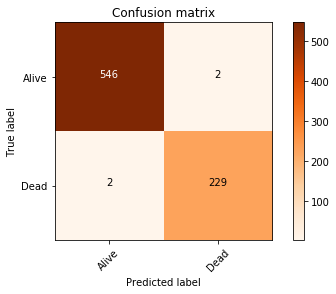

In [283]:
# Plot the confusion matrix

class_names = ["Alive","Dead"]

# Function adapted from sklearn confusion matrix docs

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, dt_preds)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()

This is awesome! The Decision Tree Classifier does a great job of predicting vital status across this cancer dataset.